In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/'
scratch_dir = '/pscratch/sd/j/jjpim/'
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

#nitya's data
nitya = Table.read(scratch_dir + 'H_alpha_HIvel_BB_refit_ba.fits')

In [3]:
#defining functions
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [4]:
nitya['v_R90']=np.nan

In [5]:
nitya[:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,v_R90
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08

In [7]:
for manga_id in np.unique(nitya['mangaid']):
    galaxy = nitya['mangaid'] == manga_id
    
    # Filter rows using the mask
    r = nitya['R90_kpc'][galaxy]
    v_max = nitya['v_max'][galaxy]
    r_turn = nitya['r_turn'][galaxy]
    alpha = nitya['alpha'][galaxy]
    
    #calculate velocities
    v = v_rot(r, v_max, r_turn, alpha)
    
    # Update the 'v_R90' column for the current manga_id
    nitya['v_R90'][galaxy] = v

In [8]:
#filter for sample requirements + create table
sample = nitya[(nitya['v_max'] > 0) & (nitya['M90_disk'] > 9) & (nitya['alpha'] <= 99) 
                     &((nitya['v_max_err'] / nitya['v_max']) <= 2) & (nitya['v_R90'] < 1000) 
                     & (nitya['v_R90'] > 10)]
print(len(sample))
sample[:5]

5603


plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,v_R90
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08

In [9]:
#plotting each mass only once
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# Extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
unique_table = Table(rows=unique, names=tf_mastertable.colnames)

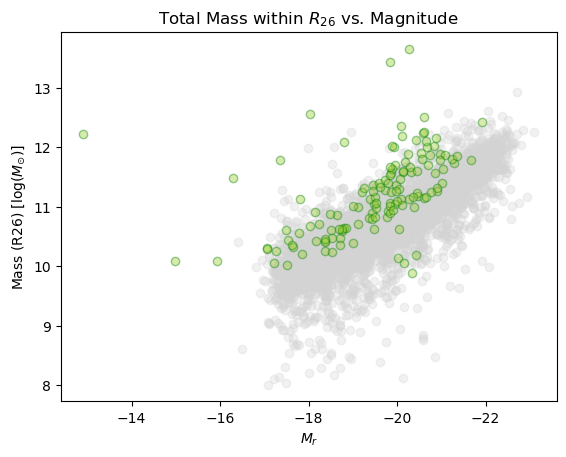

In [10]:
#plotting R26 mass vs magnitude in context of R90 mass
y = unique_table['M_R26']
x = unique_table['RABS_MAG26']

w = sample['rabsmag_NSA']
z = sample['M_R90']

#plot
plt.scatter(w, z, marker='o', color='lightgray', alpha = 0.3)
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass (R26) [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title(r"Total Mass within $R_{26}$ vs. Magnitude")
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_r26_mass_magplot.png', dpi=300)

In [ ]:
#plotting 3.5 R26 mass vs magnitude in context of 3.5 R90 mass
x = unique_table['RABS_MAG26']
y = unique_table['M_3P5R26']

w = sample['rabsmag_NSA']
z = sample['M']

plt.scatter(w, z, marker='o', color='lightgray', alpha = 0.3)
plt.scatter(x, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass (3.5 R26) [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("3.5 R26 Mass vs. Magnitude")
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_3p5r26_mass_magplot.png', dpi=300)

In [ ]:
#plotting R26 and 3.5 R26 mass vs magnitude in context of R90 and 3.5 R90 mass
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_3P5R26']
#nityas data
a = sample['rabsmag_NSA']
b = sample['M']
c = sample['rabsmag_NSA']
d = sample['M_R90']
#plot
plt.scatter(a, b, marker='o', color='lightgray', alpha = 0.4)
plt.scatter(c, d, marker='o', color='lightgray', alpha = 0.2)
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26')
plt.scatter(w, z, marker='o',  color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = '3.5 R26')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_r26_3p5r26__mass_magplot.png', dpi=300)

Stellar Mass Plots

In [ ]:
# read in first table
table = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits')
#read in second table
table_2 = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/provabgs/v1.0/BGS_ANY_full.provabgs.sv3.v0.hdf5')

# find common target ids
t1 = table[table['LOGM'] > 0]
t2 = table_2[table_2['PROVABGS_LOGMSTAR_BF'] > 0]
common_ids = np.intersect1d(t1['TARGETID'], t2['TARGETID'])

# define function
def filter_table_by_ids(table, common_ids):
    return table[np.in1d(table['TARGETID'], common_ids)]

common_data_table = filter_table_by_ids(t1, common_ids)
common_data_table_2 = filter_table_by_ids(t2, common_ids)

# sort by targetid
common_data_table.sort('TARGETID')
common_data_table_2.sort('TARGETID')

In [ ]:
#total mass vs. cigale stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_STELLAR_CIGALE']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color='lightgray', alpha = 0.4)
plt.scatter(c, d, marker='o', color='lightgray', alpha = 0.2)
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(w, z, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_cigale_stellar_total__mass_magplot.png', dpi=300)

In [ ]:
#total mass vs. provabgs stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color='lightgray', alpha = 0.4)
plt.scatter(c, d, marker='o', color='lightgray', alpha = 0.2)
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_provabgs_stellar_total__mass_magplot.png', dpi=300)

In [ ]:
#total mass vs. provabgs and cegale stellar mass in context of R90 and stellar mass in R90
#plotting
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['M_STELLAR_CIGALE']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color='lightgray', alpha = 0.4)
plt.scatter(c, d, marker='o', color='lightgray', alpha = 0.2)
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_both_stellar_total__mass_magplot.png', dpi=300)

In [ ]:
#stellar mass vs total mass R26 for both
#plotting
y = unique_table['M_R26']
x_cigale = unique_table['M_STELLAR_CIGALE']
x_provabgs = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['M90_disk']
b = sample['M_R90']

#plot
plt.scatter(a, b, marker='o', color='lightgray', alpha = 0.4)
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
#plt.ylim(7.5, 14)
#plt.xlim(7.5, 14)
#plt.plot([7.5, 14], [7.5,14], ls = ':')
plt.ylabel(r"Total Mass in $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass within $R_{26}$")
plt.legend()
plt.savefig(v_dir + 'context_stellar_total__mass_plot.png', dpi=300)
plt.show()